In [1]:
from numpy import sin
def sin_model(t, freq, phase):
    return sin(2*pi*(freq*t + phase))

In [2]:
import geopandas as gpd

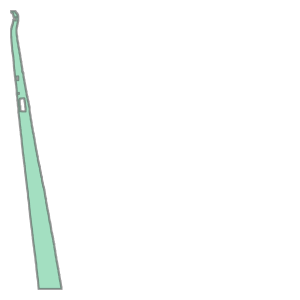

In [8]:
shp = gpd.read_file('/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/test.shp')
shp['geometry'][0]

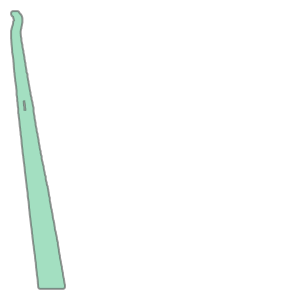

In [20]:
a = shp.buffer(50)[0]
a

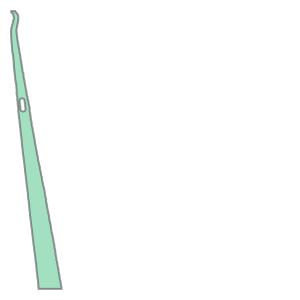

In [26]:
b = a.buffer(-50)
polygon = b
b

In [34]:
c = b.exterior

In [36]:
from centerline.geometry import Centerline

attributes = {"id": 1, "name": "polygon", "valid": True}
centerline = Centerline(c, **attributes)
centerline.id == 1

InvalidInputTypeError: Input geometry must be of type shapely.geometry.Polygon or shapely.geometry.MultiPolygon!

In [41]:
import os
import cv2
import copy
import gdal
import json
import glob
import fiona
import random
import skimage
import argparse
import rasterio
import colorsys
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely import geometry
# from models.core import *
from fiona.crs import from_epsg
# from scripts.predict import inference


def write_image(data, height, width, numband, crs, tr, out):
    """
        Export numpy array to image by rasterio.
    """
    with rasterio.open(out,'w',driver='GTiff',height=height,
                        width=width,count=numband,dtype=data.dtype,crs=crs,
                        transform=tr,) as dst:
                        dst.write(data)

def list_polygon_to_list_geopolygon(list_polygon, geotransform):
    list_geopolygon = []
    for polygon in list_polygon:
        geopolygon = polygon_to_geopolygon(polygon, geotransform)
        list_geopolygon.append(geopolygon)
    return list_geopolygon

def polygon_to_geopolygon(polygon, geotransform):
    temp_geopolygon = []
    for point in polygon:
        geopoint = point_to_geopoint(point, geotransform)
        temp_geopolygon.append(geopoint)
    geopolygon = tuple(temp_geopolygon)
    return geopolygon

def point_to_geopoint(point, geotransform):
    topleftX = geotransform[0]
    topleftY = geotransform[3]
    XRes = geotransform[1]
    YRes = geotransform[5]
    geopoint = (topleftX + point[0] * XRes, topleftY + point[1] * YRes)
    return geopoint

def contour_to_polygon(contour):
    list_point = []
    try:
        for point in contour:
            [x,y] = point[0]
            point_in_polygon = (x,y)
            list_point.append(point_in_polygon)
        # print(contour[0])
        [x,y] = contour[0][0]
        point_in_polygon = (x,y)
        list_point.append(point_in_polygon)
        poly = tuple(list_point)
    except Exception:
        poly = ()
    return poly


def list_contour_to_list_polygon(list_contour):
    list_polygon = []
    for contour in list_contour:
        poly = contour_to_polygon(contour)
        list_polygon.append(poly)
    return list_polygon

def rm_polygon_err(list_polygon):
    list_poly_good =[]
    for polygon in list_polygon:
        if len(polygon) >= 3:
            list_poly_good.append(polygon)
    return list_poly_good

def export_shapefile(list_polygon, geotransform, outputFileName, driverName, coordinate,proj_str):

    # data
    list_contour_not_holes = list_polygon[0]
    list_list_contour_parent = list_polygon[1]

    # # # xử lý không có lỗ
    list_polygon_not_holes = []
    list_poly_not_holes = list_contour_to_list_polygon(list_contour_not_holes)
    list_poly_not_holes = rm_polygon_err(list_poly_not_holes)
    list_geopolygon_not_holes = list_polygon_to_list_geopolygon(list_poly_not_holes, geotransform)
    # print(list_geopolygon_not_holes)
    for geopolygon in list_geopolygon_not_holes:
        geopolygon_not_holes = list(geopolygon)
        myPoly = geometry.Polygon(geopolygon_not_holes)
        # print(myPoly)
        list_polygon_not_holes.append(myPoly)

    # xử lý có lỗ
    list_polygon_have_holes = []
    for list_contour_parent in list_list_contour_parent:
        # những thằng là cha
        contour_parents = list_contour_parent[0]
        poly_parents = contour_to_polygon(contour_parents)
        geopolygon_parent = polygon_to_geopolygon(poly_parents, geotransform)
        geopolygon_parent = list(geopolygon_parent)
        # print(geopolygon_parent)
        #những thăng là con
        list_contour_child = np.delete(list_contour_parent,0)
        list_contour_child = rm_polygon_err(list_contour_child)
        list_poly_child = list_contour_to_list_polygon(list_contour_child)
        list_geopolygon_child = list_polygon_to_list_geopolygon(list_poly_child, geotransform)
        # print(list_geopolygon_child)
        #tung geopolygon đươc cho vao 1 list
        geopolygon_child_list = []
        for geopolygon_child in list_geopolygon_child:
            geopolygon_child_list.append(list(geopolygon_child))
        # print(geopolygon_child_list)
        myPoly = geometry.Polygon(geopolygon_parent,geopolygon_child_list)
        list_polygon_have_holes.append(myPoly)

    list_polygon = list_polygon_not_holes + list_polygon_have_holes
    if coordinate != None:
        # print("anh",coordinate)
        wgs84 = fiona.crs.from_epsg(coordinate)
    else:
        wgs84 = fiona.crs.from_string(proj_str)
    schema = {'geometry':'Polygon', 'properties': {'id': 'int'}}
    with fiona.open(outputFileName, 'w', crs=wgs84,driver='ESRI Shapefile',schema=schema) as c:
        for polygon in list_polygon:
            c.write({
                    'geometry': geometry.mapping(polygon),
                    'properties': {'id': 1}
                    }) 

def list_cnt_to_list_cnx(list_cnt):
    list_cnx =[]
    for i in range(len(list_cnt)):
    #    cnx = np.reshape(list_cnt[i], (1,len(list_cnt[i]),2))
        cnx = np.reshape(list_cnt[i], (len(list_cnt[i]),2))
        cnx = cnx.astype(int)
        list_cnx.append(cnx)
    return list_cnx

def unique(list1): 
    x = np.array(list1) 
    return np.unique(x)

def read_mask(url):
    with rasterio.open(url) as src:
        array = src.read()[0]
    return array

def raster_to_vector(base_path,outputFileName):
    
    mask_base = read_mask(base_path)
    # mask_base = 1 - mask_base
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

    closing = cv2.morphologyEx(mask_base, cv2.MORPH_CLOSE, kernel3)
    for i in range(5):
        closing = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, kernel2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel2)
    del closing
    for i in range(5):
        opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel2)
    input_img = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel3)

    contours, hierarchy = cv2.findContours(input_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) 
    #danh sach contour khong co lo
    list_contour_not_holes = []
    #danh sach cac contour co lo
    list_contour_holes = []
    parents = []

    for i in range(len(contours)):
        if hierarchy[0][i][2] < 0 and hierarchy[0][i][3] < 0 :
            if cv2.contourArea(contours[i]) > 5:
                list_contour_not_holes.append(contours[i])
        if hierarchy[0][i][3] > 0  :
            parents.append(hierarchy[0][i][3])
            list_contour_holes.append(contours[i])
            
    parents = unique(parents)

    #danh sach cac contour la cha, moi danh sach thi thang dau luon la cha
    list_list_contour_parent = []

    for i in range(len(parents)):
        contour_parent = [contours[parents[i]]]
        for j in range(len(contours)):
            if hierarchy[0][j][3] == parents[i]:
                contour_parent.append(contours[j])
        list_list_contour_parent.append(contour_parent)

    # chua 2 thu la list polygon khong co lo, va list cac contour co lo
    polygons_result = [list_contour_not_holes, list_list_contour_parent]

    dataset_base = gdal.Open(base_path)
    driverName = "ESRI Shapefile"
    outputFileName = outputFileName
    with rasterio.open(base_path, mode='r+') as src:
        projstr = (src.crs.to_proj4())
        crs = src.crs
        check_epsg = crs.is_epsg_code
        coordinate = src.crs.to_epsg()
    geotransform = dataset_base.GetGeoTransform()
    export_shapefile(polygons_result, geotransform, outputFileName, driverName, coordinate=coordinate,proj_str = projstr)
    

In [44]:
for i in glob.glob('/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/results/*.tif'):
    shp_path = i.replace('.tif', '.shp').replace('results', 'shape_2')
    # mask = rasterio.open(i).read()
    raster_to_vector(i, shp_path)
    # if len(np.unique(mask))>1:
    #     raster_to_vector(i, shp_path)
    #     try:
    #         df1 = None
    #         df = gpd.read_file(shp_path)
    #         df1 = copy.deepcopy(df)
    #         df1['geometry'] = df.centroid
    #         df1.to_file(shp_path.replace('.shp', '_centroids.shp'))
    #     except:
    #         pass

In [64]:
bonus_negative = []
for shp1 in glob.glob('/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/shape_1/*.shp'):
    shp2 = shp1.replace('shape_1', 'shape_2').replace('.shp', '_result.shp')
    df1 = gpd.read_file(shp1)
    df2 = gpd.read_file(shp2)
    duplicate_file = None
    for i in df1.geometry:
        for j in df2.geometry:
            union = i.intersection(j)
            if union:
                pass
            else:
                duplicate_file = shp2
    if duplicate_file:
        bonus_negative.append(duplicate_file)
    # print(shp1)
    # print(shp2)
    # print(duplicate_file)
    # print("###")

In [74]:
import shutil

bonus_negative_path = '/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/bonus_negative'
for neg_file in bonus_negative:
    img_neg = os.path.join(bonus_negative_path, 'img' ,os.path.basename(neg_file).replace('_result.shp', '.tif'))
    mask_neg = os.path.join(bonus_negative_path, 'mask' ,os.path.basename(neg_file).replace('_result.shp', '.tif'))
    if not os.path.exists(img_neg):
        old_img = neg_file.replace('shape_2', 'img').replace('_result.shp', '.tif')
        shutil.copy2(old_img, img_neg)
        
    if not os.path.exists(mask_neg):
        old_mask = neg_file.replace('shape_2', 'mask').replace('_result.shp', '.tif')
        shutil.copy2(old_mask, mask_neg)

In [202]:
from multiprocessing.pool import Pool
from functools import partial
import multiprocessing

core = multiprocessing.cpu_count()

num_band = 3
folder_img = glob.glob('/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/img_jpg/*.jpg')
out_path = '/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/test'
with rasterio.open('/home/quyet/DATA_ML/Projects/video_hold/DJI_0007/abc/mask_tif/DJI_0007_0_0m:0s_result.tif') as src_base:
    height = src_base.height
    width = src_base.width
    crs = src_base.crs
    tr = src_base.transform
    meta = src_base.profile

def convert_jpg_to_tif(path, out_path, num_band, meta):
    img_rgb = rasterio.open(path).read().swapaxes(0,1).swapaxes(1,2)
    # c,h,w = img_rgb.shape
    pts = np.array([[1920-195,0], [1920+195,0],[1920+1395,2160],[1920-1395,2160]])
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask[mask!=0]=255

    img_rgb[mask!=255]=0
    crop_img = img_rgb.swapaxes(2,1).swapaxes(1,0)
    # crop_img = img_rgb[..., :, int(w/4):int(w-w/4)]
    # crop_img = img_rgb
    C,h,w = crop_img.shape
    meta['height']= h
    meta['width']= w
    meta['count']= c
    meta['dtype']='uint8'
    outpath = os.path.join(out_path, os.path.basename(path).replace('.jpg', '.tif'))
    new_dataset = rasterio.open(outpath, 'w', **meta)
    for i in range(num_band):
        new_dataset.write(crop_img[i],i+1)
    new_dataset.close()


if not os.path.exists(out_path):
    os.mkdir(out_path)
    
p_cnt = Pool(processes=int(core/2))
result = p_cnt.map(partial(convert_jpg_to_tif, out_path=out_path, num_band=num_band, meta=meta), folder_img)
p_cnt.close()
p_cnt.join()

ERROR 1: PROJ: proj_create_from_database: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABA

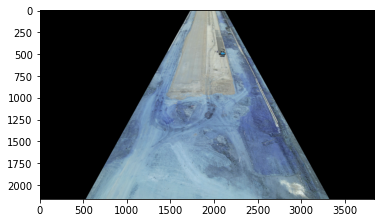

In [150]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/img_jpg/DJI_0006-001-002_122_2m:2s.jpg")
pts = np.array([[1920-195,0], [1920+195,0],[1920+1395,2160],[1920-1395,2160]])

# ## (1) Crop the bounding rect
# rect = cv2.boundingRect(pts)
# x,y,w,h = rect
# croped = img[y:y+h, x:x+w].copy()

# ## (2) make mask
# pts = pts - pts.min(axis=0)

mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
mask[mask!=0]=255

img[mask!=255]=0
# ## (3) do bit-op
# dst = cv2.bitwise_and(croped, croped, mask=mask)

# ## (4) add the white background
# bg = np.ones_like(croped, np.uint8)*255
# cv2.bitwise_not(bg,bg, mask=mask)
# dst2 = bg+ dst


# cv2.imwrite("croped.png", croped)
# cv2.imwrite("mask.png", mask)
# cv2.imwrite("dst.png", dst)
# cv2.imwrite("dst2.png", dst2)
plt.imshow(img)

In [199]:
path = '/home/quyet/DATA_ML/Projects/change_detection/new_video/tarmac/img_jpg/DJI_0006-001-002_122_2m:2s.jpg'
img_rgb = rasterio.open(path).read().swapaxes(0,1).swapaxes(1,2)
# c,h,w = img_rgb.shape
pts = np.array([[1920-195,0], [1920+195,0],[1920+1395,2160],[1920-1395,2160]])
mask = np.zeros(img.shape, np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask[mask!=0]=255

img_rgb[mask!=255]=0
# crop_img = img
crop_img = img_rgb.swapaxes(2,1).swapaxes(1,0)

c,h,w = crop_img.shape
meta['height']= h
meta['width']= w
meta['count']= c
meta['dtype']='uint8'
outpath = os.path.join(out_path, os.path.basename(path).replace('.jpg', '.tif'))
new_dataset = rasterio.open(outpath, 'w', **meta)
for i in range(num_band):
    new_dataset.write(crop_img[i],i+1)
new_dataset.close()

ERROR 1: PROJ: proj_create_from_database: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


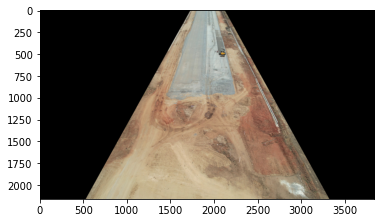

In [200]:
plt.imshow(crop_img.swapaxes(0,1).swapaxes(1,2))

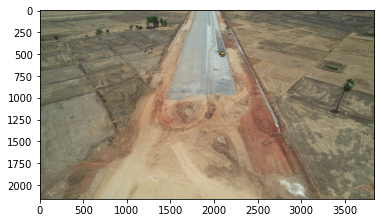

In [190]:
plt.imshow(img_rgb.swapaxes(0,1).swapaxes(1,2))

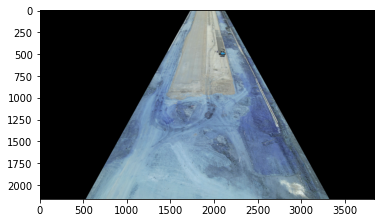

In [197]:
plt.imshow(img)

In [193]:
mask.shape

(2160, 3840)

In [203]:
# read file line by line
file = open( "/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006.SRT", "r")
lines = file.readlines()

In [219]:
from itertools import islice

def check(letter):
    if '</font>' in letter:
        return False
    else:
        return True

with open("/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006.SRT") as f:
    lines = f.read().splitlines()
str_list = list(filter(None, lines))
str_list = list(filter(check, str_list))

In [234]:
str_list[0:5]

['1',
 '00:00:00,000 --> 00:00:00,040',
 '<font size="36">SrtCnt : 1, DiffTime : 40ms',
 '2022-04-05 10:05:56,299,398',
 '[iso : 100] [shutter : 1/1250.0] [fnum : 280] [ev : 0] [ct : 5051] [color_md : default] [focal_len : 224] [dzoom_ratio: 10000, delta:0],[latitude: 17.000956] [longitude: 80.000040] [altitude: 44.300000] ']

In [261]:
str_dict = {}
for index in range(0, len(str_list), 5):
    list_with_empty_strings = str_list[index+4].split(',')[-1].replace('[', '').replace(']', '').replace(':', '').split(' ')
    new_list = list(filter(lambda x: x != '', list_with_empty_strings))
    
    str_dict.update({'%s'%(str_list[index]): {'%s'%(new_list[0]):'%s'%(new_list[1]),
                                              '%s'%(new_list[2]):'%s'%(new_list[3]),
                                              '%s'%(new_list[4]):'%s'%(new_list[5]),
                                             }})

In [259]:
list_with_empty_strings = str_list[index+4].split(',')[-1].replace('[', '').replace(']', '').replace(':', '').split(' ')
new_list = list(filter(lambda x: x != '', list_with_empty_strings))

In [262]:
str_dict

{'1': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '2': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '3': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '4': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '5': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '6': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '7': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '8': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '9': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '10': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '11': {'latitude': '17.000956',
  'longitude': '80.000040',
  'altitude': '44.300000'},
 '12': {'latitude': '17.000956